# Creating Icons For the Pokédex: An Application of Generative Adversarial Networks
This Jupyter Notebook contains a neural network which trains on and generates images like those from the `Icons/` or `Artwork/` directory, both of which contain web-scraped Pokémon icons. Note that adjustments must be made for the neural network to train using the help of a GPU (which is highly recommended), as the original was trained within a VirtualBox without access to a GPU.

### Defining some Hyperparameters and Dataset

First, define the directory for the images dataset, along with the batch size and image size that will be used for training. Additionally, the number of channels used for training the images must be defined as 3 for use with any color. Let `ngf` and `ndf` represent the number of features within the Generator network and Discriminator network, respectively, and `nz` be the features in latent space. 

In [1]:
dataroot = 'Artwork/'

batch_size = 128
image_size = 64

nc = 3
ngf = 64
ndf = 64
nz = 128

Some hyperparameters of the neural network then need to be defined, as well as the use of a GPU (let `0` represent a CPU).

In [2]:
import torch

num_epochs = 500
lr = 0.0002
beta1 = 0.5

ngpu = 0
device = torch.device('cpu')

The dataset may then be instantiated by using an `ImageFolder` available in `torchvision.datasets` along with some transformation methods from `torchvision.transforms`. An iterable form of the dataset, `dataloader`, can be created afterwards. 

In [3]:
import numpy as np
import torchvision.datasets as dset
import torchvision.transforms as transforms

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

It may be helpful to visualize the dataset to ensure that everything looks as intended. Import `matplotlib.pyplot` alongside `torchvision.utils` to view a sample grid of training images.

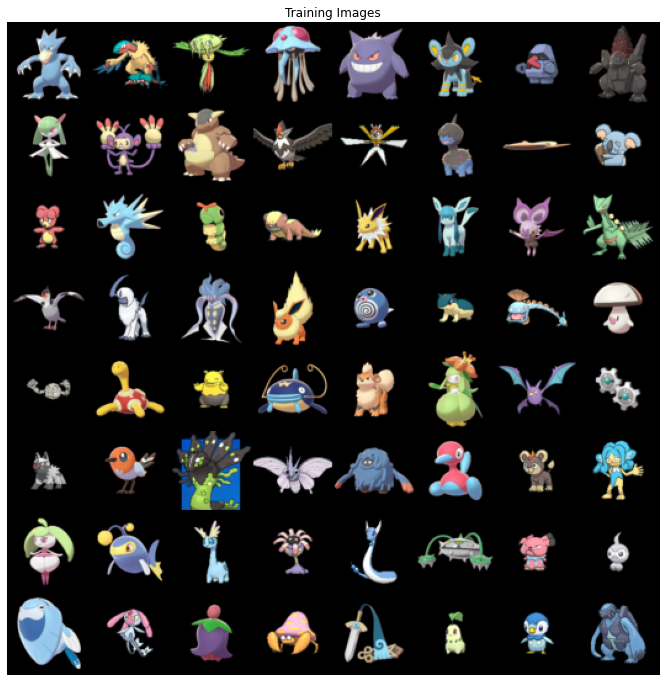

In [4]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
%matplotlib inline

real_batch = next(iter(dataloader))
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)));

The weight initialization for the Generator's network as well as the Discriminator's network may now be defined: a standard Gaussian distribution is generated for `ConvTranspose2d` layers and likewise for `BatchNorm2d` layers, although with the addition of a constant term. The `BatchNorm2d` layers may be replaced or adjusted for input terms to allow for other types of initialization, such as Xavier or He. 

In [5]:
import torch.nn as nn
import torch.nn.parallel

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Creating the Generator and Discriminator

The Generator structure is created from multiple interwoven layers from batch normalization and two-dimenstional transposed convolutions, with the added PReLU rectifier. LeakyReLU, while typically not a bad choice for the Generator network of GANs, yielded subpar results in comparison to PReLU here.

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 8 * ngf, 4, 1, 0, bias=False),
            nn.BatchNorm2d(8 * ngf),
            nn.PReLU(),
            
            nn.ConvTranspose2d(8 * ngf, 4 * ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4 * ngf),
            nn.PReLU(),
            
            nn.ConvTranspose2d(4 * ngf, 2 * ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2 * ngf),
            nn.PReLU(),
            
            nn.ConvTranspose2d(2 * ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.PReLU(),
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

Notice that the second parameter for a `nn.ConvTranspose2d` term serves as the parameter for `nn.BatchNorm2d` and as the first parameter for the following `nn.ConvTranspose2d` layer. The inputs are halved for each advancing layer.

Next, instantiate the network to the CUDA device (if available: the original was done within VirtualBox and therefore -- unfortunately -- on CPU) and apply the Gaussian weight initialization to the Generator network.

In [7]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): PReLU(num_parameters=1)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): PReLU(num_parameters=1)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   

The Discriminator serves as a complement to the Generator -- more specifically an *adversary* -- and therefore will have a structure similar to the Generator but in an opposite direction. Notice, now, that LeakyReLU has superseded the ReLU activation function here parallel to how the hyperbolic tangent function has been replaced by the sigmoid activation function. 

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, 2 * ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2 * ndf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(2 * ndf, 4 * ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4 * ndf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(4 * ndf, 8 * ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(8 * ndf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(8 * ndf, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Instantiate the Discriminator to the CUDA device (again, if available) as previously done with the Generator network. Initialize the weights per a Gaussian distribution.

In [9]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Loss and Optimization
 The labelling convention for training is established per the cell below, in addition to the loss metric and optimizers. Note that `BCELoss` is essentially for entropy reduction (and therefore information gain -- the two are different sides of the same coin) and that a specialized optimizer, like the conjugate gradient method or a novel optimizer, may be implemented to help improve the performance of the neural network. `Adam` is a decent optimizer and should suffice for demonstration.

In [10]:
import torch.optim as optim

criterion = nn.BCELoss()

# The progress of the Generator will be saved over noise
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training

This section will take, without a doubt, the most time out of any other cell in the Jupyter Notebook. Training time can be immensely reduced by using any available CUDA device (a GPU), so it is strongly advised to use such a CUDA device if available. Otherwise, be prepared to spend a *great* amount of time training through the use of a CPU.

The library `tqdm` is used regardless of CUDA devices so that the progress of training can easily be visualized. Essentially, the training process will iterate over the dataloader and calculate the loss and gradients of each batch within the Discriminator network for original images. Then, a tensor of latent vectors is created for the Generator to produce images on. The loss and gradients of the batch are calculated again within the Discriminator for fake images, where the fake-images and real-images gradients are then summed for the actual residual. With the updated Discriminator, the loss and gradients of the Generator network are then calculated. This process is repeated `num_epochs` times.

In [11]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore') # This hides the Pillow warnings at the risk of hiding ALL warnings. Livin' like Larry.

img_list = []
iters = 0

for epoch in tqdm(range(num_epochs)):
    for i, data in enumerate(dataloader, 0):
        
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

100%|██████████| 500/500 [5:40:00<00:00, 40.80s/it]  


### Visualizing the Product

Use `matplotlib.pyplot` to compare the real images to the generated ones by generating a subplot. The generated images are placed in the righthand subplot. 

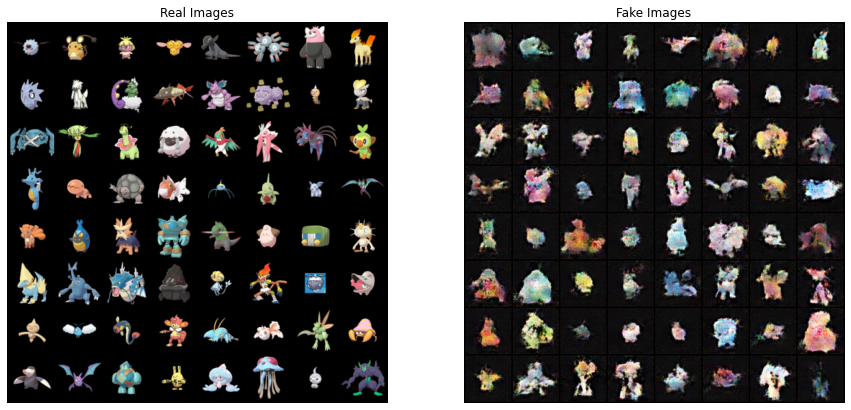

In [12]:
# Select a sample of real images from the dataloader
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Real Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1,2,0)))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()

There is some noise in the generated images, as there is still much room for improvement; however, the results are not too bad considering that the neural network had originally been trained without access to a GPU nor with any fancy graphical upscaling methods implemented.

Credit is given to Nathan Inkawhich, author of the official [Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) for Deep Convolutional Generative Adversarial Networks. This Jupyter Notebook shamelessly borrows the structure used in the above link, with details changed where appropriate for improved results. After all, there is no point in re-inventing the wheel!